# Clustering Test

In [1]:
import pandas as pd
import numpy as np
import concurrent.futures as cf
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint
import nltk
import pickle
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import KMeans
from collections import Counter

pd.set_option('display.max_columns', None)

%matplotlib inline

In [2]:
path_in = '~/Dropbox/Burning Glass/Data/random_data/'
path_out = '~/Dropbox/Burning Glass/Analysis/unsupervised_approach/'
models = path_out + 'models/'

In [3]:
%%time

df = pd.read_csv(path_in + 'all_years_rand_samp.csv', 
                 parse_dates=['JobDate'], low_memory=False)
df.head()

CPU times: user 16.1 s, sys: 4.49 s, total: 20.6 s
Wall time: 21.7 s


,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience
0,en,Irvine,CA,Pt Faculty Pool - Recycling & Zero Waste,2013-01-03,Posting Details South Orange County Community ...,110103522,33.6881,-117.7880,92604,Orange,11244.0,DV064204|MT063110,31080: Metropolitan Statistical Area|348: Comb...,Saddleback College,NaN,25-119900,NaN,0,Education,Education and Training: Instructional and Curr...,{'Course Development': 'Education and Training...,False,Bachelor of Arts,Bachelor of Arts|Bachelor's|Master's,030103,6.0,6113.0,25-1199.91,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,16|18,Pt Faculty Pool - Recycling & Zero Waste,18.0,16.0,College Professor / Instructor,2) years|6) years|Two years
1,en,Marbury,MD,Class A Cdl Truck Driver,2013-11-20,Experienced Class A CDL Truck Drivers (20658),255851194,38.5624,-77.1639,20658,Charles,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,Usa Truck,Class A CDL Truck Driver,53-303200,NaN,0,Job Board,NaN,{},False,NaN,NaN,NaN,NaN,484.0,53-3032.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Class A CDL Truck Driver,NaN,NaN,Tractor-Trailer Truck Driver (General),NaN
2,en,Auburn,AL,Apartment Community Maintenance Technician - S...,2013-09-06,"Posted: 2013-09-05, 4:16PM EDT\n\nApartment Co...",246911326,32.5824,-85.5126,36830,Lee,NaN,MT011222,12220: Metropolitan Statistical Area,NaN,Maintenance Technician,49-907100,NaN,0,FreeJobBoard,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,Higher Secondary Certificate,NaN,2.0,NaN,49-9071.91,NaN,NaN,NaN,NaN,NaN,NaN,1-6,mid,12,Maintenance Technician,NaN,12.0,Building and General Maintenance Technician,minimum of six months|two years
3,en,Anchorage,AK,Registered Nurse - All Specialties And Shifts,2013-08-30,Description:\n* Registered Nurses - All Spec...,244857419,61.2157,-149.8690,99501,Anchorage,NaN,MT021126,11260: Metropolitan Statistical Area,Nadiagruzd,Registered Nurse,29-114100,NaN,0,Recruiter,NaN,{},False,NaN,NaN,NaN,NaN,62.0,29-1141.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Registered Nurse,NaN,NaN,Registered Nurse,NaN
4,en,Madison,WI,Project Manager,2013-11-30,"Apex Systems, Inc Skills: Project ma...",420796045,43.1153,-89.5249,53562,Dane,NaN,MT553154,31540: Metropolitan Statistical Area,NaN,NaN,15-119909,"Apex Systems, Inc.",0,Job intermediary,Finance: Cost Accounting;Specialized Skills|Ma...,{'Cost Analysis': 'Finance: Cost Accounting;Sp...,False,NaN,NaN,NaN,7.0,NaN,15-1199.95,NaN,NaN,NaN,NaN,fulltime,permanent,6+,high,NaN,Project Manager,NaN,NaN,IT Project Manager,7 years|5 years|3 years


# Data Inspection & Cleaning

In [4]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476428 entries, 0 to 476427
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   Language                          476428 non-null  object        
 1   CanonCity                         466244 non-null  object        
 2   CanonState                        476394 non-null  object        
 3   CleanJobTitle                     476269 non-null  object        
 4   JobDate                           476428 non-null  datetime64[ns]
 5   JobText                           473483 non-null  object        
 6   JobID                             476428 non-null  int64         
 7   Latitude                          466253 non-null  float64       
 8   Longitude                         466253 non-null  float64       
 9   CanonPostalCode                   465000 non-null  object        
 10  CanonCounty                     

In [5]:
df.shape

(476428, 43)

In [6]:
missing_pct = df.isna().sum() / df.shape[0] * 100
missing_pct

Language                             0.000000
CanonCity                            2.137574
CanonState                           0.007136
CleanJobTitle                        0.033373
JobDate                              0.000000
JobText                              0.618142
JobID                                0.000000
Latitude                             2.135685
Longitude                            2.135685
CanonPostalCode                      2.398684
CanonCounty                          2.159403
DivisionCode                        68.090666
LMA                                  2.479073
MSA                                  4.781625
CanonEmployer                       36.437405
CanonJobTitle                       35.178453
ConsolidatedONET                     3.593618
CanonIntermediary                   85.666040
InternshipFlag                       0.000000
Source                               3.168789
CanonSkillClusters                   8.660700
CanonSkills                       

A lot of the missing values in the `CanonEmployer` variable might be missing due to the job being posted through a recruiting agency. Let's see how many of these missing value have a value available in the `CanonIntermediary` column.

In [7]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), :].shape

(68284, 43)

As we can see, about ~68,000 missing values in `CanonEmployer` have a matching Recruiting Agency in `CanonIntermediary`.

In [8]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), ['CanonEmployer', 'CanonIntermediary']].head()

,CanonEmployer,CanonIntermediary
4,NaN,"Apex Systems, Inc."
10,NaN,Nigel Frank International
12,NaN,Kelly Services
20,NaN,Elance
31,NaN,Randstad


In [9]:
df.shape[0] * .15

71464.2

We can also see that the `CanonIntermediary` variable has about `0.15` of non-missing values in it, which is almost the same amount of values missing in the `CanonEmployer` var. Instead of filling in each missing value `CanonEmployer` with its respective recruiting agency for that title, what we will do instead is to fill in those missing values with the title, `Recruiting Agency`.

In [10]:
print(f'Missing companies BEFORE adding the Recruitment Agencies: {df.CanonEmployer.isna().sum()}')

Missing companies BEFORE adding the Recruitment Agencies: 173598


In [11]:
df.loc[(df['CanonEmployer'].isna()) & (df['CanonIntermediary'].notna()), 'CanonEmployer'] = 'Recruiting Agency'

In [12]:
print(f'Missing companies AFTER adding the Recruitment Agencies: {df.CanonEmployer.isna().sum()}')

Missing companies AFTER adding the Recruitment Agencies: 105314


In [13]:
print('Amount of Unique Employers: ', len(df['CanonEmployer'].unique()))

Amount of Unique Employers:  75805


In [14]:
# to_drop_cols = (missing_pct[missing_pct > 75]).index
# print(to_drop_cols)
# df.drop(to_drop_cols, axis=1, inplace=True)
# print(df.shape)

In [15]:
print('Amount of Unique Jobs: ', len(df['CleanJobTitle'].unique()))

Amount of Unique Jobs:  271225


In [16]:
print('Percentage of Unique Jobs in the Dataset: %.2f' % (len(df['CleanJobTitle'].unique()) / df.shape[0] * 100))

Percentage of Unique Jobs in the Dataset: 56.93


In [17]:
df['year'] = df['JobDate'].dt.year
print("Observations per Year")
df['year'].value_counts()

Observations per Year


2011    50144
2012    49926
2007    47695
2016    43376
2015    40945
2010    40487
2017    39534
2020    35000
2019    35000
2018    35000
2014    33690
2013    25631
Name: year, dtype: int64

# More Cleaning

We will filter out any `NaN` values from the companies, job description, and job title variables.

In [18]:
df = df[df['CanonEmployer'].notna()]
df = df[df['JobText'].notna()]
df = df[df['CleanJobTitle'].notna()]

In [19]:
df.shape

(368555, 44)

In [20]:
%%time

df['clean_text'] = df['JobText'].apply(lambda x: ' '.join(list(filter(None, x.split('\n')))))
df['charac_text_len'] = df['clean_text'].apply(len)
df['low_clean'] = df['clean_text'].apply(lambda x: x.lower())

CPU times: user 3.58 s, sys: 645 ms, total: 4.22 s
Wall time: 4.24 s


In [21]:
%%time

df['list_job_text'] = df['clean_text'].apply(lambda x: list(filter(None, x.split())))
df['list_title_words'] = df['CleanJobTitle'].apply(lambda x: list(filter(None, x.split())))

CPU times: user 42.1 s, sys: 1min 50s, total: 2min 32s
Wall time: 3min 19s


In [22]:
df['len_job_text'] = df['list_job_text'].apply(len)

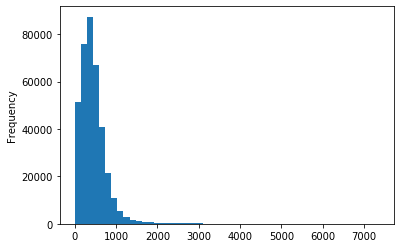

In [23]:
df['len_job_text'].plot(kind='hist', bins=50)

We will also get rid of job descriptions with less than, or equal to, 75 words.

In [24]:
df['len_job_text'].describe()

count    368555.000000
mean        442.574134
std         336.774133
min           1.000000
25%         233.000000
50%         391.000000
75%         578.000000
max        7370.000000
Name: len_job_text, dtype: float64

In [25]:
df = df.loc[df['len_job_text'] > 75]
df.shape

(342332, 50)

In [26]:
df['len_job_text'].describe()

count    342332.000000
mean        474.721735
std         327.921201
min          76.000000
25%         269.000000
50%         413.000000
75%         595.000000
max        7370.000000
Name: len_job_text, dtype: float64

# Select Random Sample of 100K

The `.sample()` method below can be adjusted to whichever `n` sample you'd like. Also, note that unless you save the sample you are taking from the slightly larger data, every time you run this notebook you will get slightly different results as the sample will change.

In [27]:
%%time

df = df.sample(n=100000)
# df = df[['JobDate', 'CanonEmployer', 'CleanJobTitle', 'clean_text']]
df.reset_index(drop=True, inplace=True)
df.head()

CPU times: user 11.5 s, sys: 16.8 s, total: 28.3 s
Wall time: 40.5 s


,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text
0,en,McLean,VA,Public Sector Sap Training Lead,2012-07-05,United States US home Careers home Campus Int...,129092937,38.9498,-77.2278,22103,Fairfax,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,PricewaterhouseCoopers,NaN,15-119900,NaN,0,Company,Finance: General Accounting;Specialized Skills...,{'Accounting': 'Finance: General Accounting;Sp...,False,Bachelor of Science,Bachelor of Science|Bachelor's,NaN,6.0,541219.0,15-1199.00,NaN,NaN,NaN,NaN,NaN,NaN,6+,high,16,Public Sector Sap Training Lead,NaN,16.0,Technical Consultant / Analyst,6-10 years,2012,United States US home Careers home Campus Int...,8209,united states us home careers home campus int...,"[United, States, US, home, Careers, home, Camp...","[Public, Sector, Sap, Training, Lead]",1175
1,en,Cary,NC,Maintenance Supervisor,2017-11-12,"Maintenance Supervisor\n\nCary, North Carolina...",38298165295,35.7585,-78.7783,27511,Wake,NaN,MT373958,39580: Metropolitan Statistical Area,Real Estate,Maintenance Supervisor,49101100,NaN,0,Job Board,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,General Equivalency Degree,NaN,2.0,5312.0,49-1011.00,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,12,Maintenance Supervisor,12.0,12.0,Maintenance Supervisor,Minimum of 2-3 years,2017,"Maintenance Supervisor Cary, North Carolina - ...",1517,"maintenance supervisor cary, north carolina - ...","[Maintenance, Supervisor, Cary,, North, Caroli...","[Maintenance, Supervisor]",217
2,en,Seattle,WA,Junior Network Engineer,2016-01-30,Jr. Network Engineer Insight Global Seattle...,38014986781,47.7593,-122.2520,98028,King,42644.0,DV534264|MT534266,42660: Metropolitan Statistical Area|500: Comb...,Recruiting Agency,Junior Network Engineer,15114300,Insight Global Incorporated,0,Job intermediary,Information Technology: General Networking;Spe...,{'Cisco': 'Information Technology: General Net...,False,NaN,NaN,NaN,NaN,54.0,15-1199.02,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Junior Network Engineer,NaN,NaN,Network Engineer / Architect,NaN,2016,Jr. Network Engineer Insight Global Seattle...,1895,jr. network engineer insight global seattle...,"[Jr., Network, Engineer, Insight, Global, Seat...","[Junior, Network, Engineer]",280
3,en,Concord,CA,Loss Prevention Associate,2012-08-22,Current Job Stats 154 New Jobs Posted Today 2...,142560438,37.9834,-122.0370,94520,Contra Costa,36084.0,DV063608|MT064186,41860: Metropolitan Statistical Area|488: Comb...,Sears,Loss Prevention Associate,11-919908,NaN,0,Company from Job Board,Public Safety and National Security: Loss Prev...,{'Asset Protection': 'Public Safety and Nation...,False,NaN,NaN,NaN,NaN,452111.0,33-1099.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loss Prevention Associate,NaN,NaN,Loss Prevention / Asset Protection Specialist,NaN,2012,Current Job Stats 154 New Jobs Posted Today 2...,2479,current job stats 154 new jobs posted today 2...,"[Current, Job, Stats, 154, New, Jobs, Posted, ...","[Loss, Prevention, Associate]",347
4,en,Cleveland,TN,Sewing Machine Operator,2015-06-10,Randstad Sewing Machine Operator in Cleveland ...,37909604434,41.5037,-84.8707,37311,Bradley,NaN,MT471742,17420: Metropolitan Statistical Area,Recruiting Agency,Sewing Machine Operator,51603100,Rand

Let's make sure there are no missing values in this random sample.

In [28]:
df.isna().any()

Language                            False
CanonCity                            True
CanonState                           True
CleanJobTitle                       False
JobDate                             False
JobText                             False
JobID                               False
Latitude                             True
Longitude                            True
CanonPostalCode                      True
CanonCounty                          True
DivisionCode                         True
LMA                                  True
MSA                                  True
CanonEmployer                       False
CanonJobTitle                        True
ConsolidatedONET                     True
CanonIntermediary                    True
InternshipFlag                      False
Source                               True
CanonSkillClusters                   True
CanonSkills                         False
IsDuplicate                         False
CanonMinimumDegree                

In [29]:
def normalize_doc(doc):
    """
    This function normalizes your list of documents by taking only
    words, numbers, and spaces in between them. It then filters out
    stop words if you want to.
    """
    doc = re.sub(r'[^a-zA-Z0-9\s]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    tokens = nltk.word_tokenize(doc)
    filtered_tokens = [token for token in tokens]
    # if you want to remove stopwords, uncomment the line below and
    # comment out the one above
    # filtered_tokens = [token for token in tokens if token not in stop_words]
    doc = ' '.join(filtered_tokens)
    return doc

corp_normalizer = np.vectorize(normalize_doc)

In [30]:
%%time

normal_corpus = corp_normalizer(list(df['clean_text'].values))

CPU times: user 3min 19s, sys: 22.3 s, total: 3min 41s
Wall time: 3min 55s


In [31]:
normal_corpus.shape

(100000,)

In [32]:
normal_corpus[6]

'cystic fibrosis drug sales irvine ca posted by bornholdt shivas friends executive recruiters please refer to job 09100629 summary location irvine ca us job function sales company industry biotechnology job type full time job descripton duties leading biotech company is launching a new drug for cystic fibrosis in orange county ca they are looking to hire two new reps based in irvine one will cover irvinenorth and one will cover irvinesouth two separate sales territories requirements full four year college degree already living in irvine ca or somewhere really close by needs to have 2 years of specialty drugs and hospital sales teaching hospitals and some pulmonaryrespiratory experience would be a huge huge plus education 4 years college travel percent 0 experience at least 2 years expfrience required relocation assistance no security clearance no compensation summary 100000 130000 annual contact information john bornholdt bornholdt shivas friends executive recruiters 33 concord road po

In [33]:
df['normal_text'] = normal_corpus

In [34]:
%%time

normal_titles = corp_normalizer(list(df['CleanJobTitle'].values))

CPU times: user 8.14 s, sys: 623 ms, total: 8.77 s
Wall time: 9.77 s


In [35]:
normal_titles.shape

(100000,)

In [36]:
normal_titles[0]

'public sector sap training lead'

In [37]:
df['normal_titles'] = normal_titles

In [38]:
df.head()

,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text,normal_text,normal_titles
0,en,McLean,VA,Public Sector Sap Training Lead,2012-07-05,United States US home Careers home Campus Int...,129092937,38.9498,-77.2278,22103,Fairfax,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,PricewaterhouseCoopers,NaN,15-119900,NaN,0,Company,Finance: General Accounting;Specialized Skills...,{'Accounting': 'Finance: General Accounting;Sp...,False,Bachelor of Science,Bachelor of Science|Bachelor's,NaN,6.0,541219.0,15-1199.00,NaN,NaN,NaN,NaN,NaN,NaN,6+,high,16,Public Sector Sap Training Lead,NaN,16.0,Technical Consultant / Analyst,6-10 years,2012,United States US home Careers home Campus Int...,8209,united states us home careers home campus int...,"[United, States, US, home, Careers, home, Camp...","[Public, Sector, Sap, Training, Lead]",1175,united states us home careers home campus inte...,public sector sap training lead
1,en,Cary,NC,Maintenance Supervisor,2017-11-12,"Maintenance Supervisor\n\nCary, North Carolina...",38298165295,35.7585,-78.7783,27511,Wake,NaN,MT373958,39580: Metropolitan Statistical Area,Real Estate,Maintenance Supervisor,49101100,NaN,0,Job Board,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,General Equivalency Degree,NaN,2.0,5312.0,49-1011.00,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,12,Maintenance Supervisor,12.0,12.0,Maintenance Supervisor,Minimum of 2-3 years,2017,"Maintenance Supervisor Cary, North Carolina - ...",1517,"maintenance supervisor cary, north carolina - ...","[Maintenance, Supervisor, Cary,, North, Caroli...","[Maintenance, Supervisor]",217,maintenance supervisor cary north carolina usd...,maintenance supervisor
2,en,Seattle,WA,Junior Network Engineer,2016-01-30,Jr. Network Engineer Insight Global Seattle...,38014986781,47.7593,-122.2520,98028,King,42644.0,DV534264|MT534266,42660: Metropolitan Statistical Area|500: Comb...,Recruiting Agency,Junior Network Engineer,15114300,Insight Global Incorporated,0,Job intermediary,Information Technology: General Networking;Spe...,{'Cisco': 'Information Technology: General Net...,False,NaN,NaN,NaN,NaN,54.0,15-1199.02,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Junior Network Engineer,NaN,NaN,Network Engineer / Architect,NaN,2016,Jr. Network Engineer Insight Global Seattle...,1895,jr. network engineer insight global seattle...,"[Jr., Network, Engineer, Insight, Global, Seat...","[Junior, Network, Engineer]",280,jr network engineer insight global seattle wa ...,junior network engineer
3,en,Concord,CA,Loss Prevention Associate,2012-08-22,Current Job Stats 154 New Jobs Posted Today 2...,142560438,37.9834,-122.0370,94520,Contra Costa,36084.0,DV063608|MT064186,41860: Metropolitan Statistical Area|488: Comb...,Sears,Loss Prevention Associate,11-919908,NaN,0,Company from Job Board,Public Safety and National Security: Loss Prev...,{'Asset Protection': 'Public Safety and Nation...,False,NaN,NaN,NaN,NaN,452111.0,33-1099.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loss Prevention Associate,NaN,NaN,Loss Prevention / Asset Protection Specialist,NaN,2012,Current Job Stats 154 New Jobs Posted Today 2...,2479,current job stats 154 new jobs posted today 2...,"[Current, Job, Stats, 154, New, Jobs, Posted, ...","[Loss, Prevention, Associate]",

In [39]:
sample_name = 'rands_100k_2.csv'

In [40]:
%%time

df.to_csv(path_in + sample_name, index=False)

CPU times: user 49.3 s, sys: 1min, total: 1min 50s
Wall time: 4min 51s


# Section I - Get the Data

In [3]:
%%time

sample_name = 'rands_100k_2.csv'

df = pd.read_csv(path_in + sample_name, low_memory=False)
df.head()

CPU times: user 12 s, sys: 4.4 s, total: 16.4 s
Wall time: 17.3 s


,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text,normal_text,normal_titles
0,en,McLean,VA,Public Sector Sap Training Lead,2012-07-05,United States US home Careers home Campus Int...,129092937,38.9498,-77.2278,22103.0,Fairfax,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,PricewaterhouseCoopers,NaN,15-119900,NaN,0,Company,Finance: General Accounting;Specialized Skills...,{'Accounting': 'Finance: General Accounting;Sp...,False,Bachelor of Science,Bachelor of Science|Bachelor's,NaN,6.0,541219.0,15-1199.00,NaN,NaN,NaN,NaN,NaN,NaN,6+,high,16,Public Sector Sap Training Lead,NaN,16.0,Technical Consultant / Analyst,6-10 years,2012,United States US home Careers home Campus Int...,8209,united states us home careers home campus int...,"['United', 'States', 'US', 'home', 'Careers', ...","['Public', 'Sector', 'Sap', 'Training', 'Lead']",1175,united states us home careers home campus inte...,public sector sap training lead
1,en,Cary,NC,Maintenance Supervisor,2017-11-12,"Maintenance Supervisor\n\nCary, North Carolina...",38298165295,35.7585,-78.7783,27511.0,Wake,NaN,MT373958,39580: Metropolitan Statistical Area,Real Estate,Maintenance Supervisor,49101100,NaN,0,Job Board,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,General Equivalency Degree,NaN,2.0,5312.0,49-1011.00,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,12,Maintenance Supervisor,12.0,12.0,Maintenance Supervisor,Minimum of 2-3 years,2017,"Maintenance Supervisor Cary, North Carolina - ...",1517,"maintenance supervisor cary, north carolina - ...","['Maintenance', 'Supervisor', 'Cary,', 'North'...","['Maintenance', 'Supervisor']",217,maintenance supervisor cary north carolina usd...,maintenance supervisor
2,en,Seattle,WA,Junior Network Engineer,2016-01-30,Jr. Network Engineer Insight Global Seattle...,38014986781,47.7593,-122.2520,98028.0,King,42644.0,DV534264|MT534266,42660: Metropolitan Statistical Area|500: Comb...,Recruiting Agency,Junior Network Engineer,15114300,Insight Global Incorporated,0,Job intermediary,Information Technology: General Networking;Spe...,{'Cisco': 'Information Technology: General Net...,False,NaN,NaN,NaN,NaN,54.0,15-1199.02,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Junior Network Engineer,NaN,NaN,Network Engineer / Architect,NaN,2016,Jr. Network Engineer Insight Global Seattle...,1895,jr. network engineer insight global seattle...,"['Jr.', 'Network', 'Engineer', 'Insight', 'Glo...","['Junior', 'Network', 'Engineer']",280,jr network engineer insight global seattle wa ...,junior network engineer
3,en,Concord,CA,Loss Prevention Associate,2012-08-22,Current Job Stats 154 New Jobs Posted Today 2...,142560438,37.9834,-122.0370,94520.0,Contra Costa,36084.0,DV063608|MT064186,41860: Metropolitan Statistical Area|488: Comb...,Sears,Loss Prevention Associate,11-919908,NaN,0,Company from Job Board,Public Safety and National Security: Loss Prev...,{'Asset Protection': 'Public Safety and Nation...,False,NaN,NaN,NaN,NaN,452111.0,33-1099.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Loss Prevention Associate,NaN,NaN,Loss Prevention / Asset Protection Specialist,NaN,2012,Current Job Stats 154 New Jobs Posted Today 2...,2479,current job stats 154 new jobs posted today 2...,"['Current', 'Job', 'Stats', '154', 'New', 'Job...","['L

In [4]:
len(df['CleanJobTitle'].unique())

66879

In [5]:
stopwords = nltk.corpus.stopwords.words('english')

In [6]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 52 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   Language                          100000 non-null  object 
 1   CanonCity                         98709 non-null   object 
 2   CanonState                        99992 non-null   object 
 3   CleanJobTitle                     100000 non-null  object 
 4   JobDate                           100000 non-null  object 
 5   JobText                           100000 non-null  object 
 6   JobID                             100000 non-null  int64  
 7   Latitude                          98710 non-null   float64
 8   Longitude                         98710 non-null   float64
 9   CanonPostalCode                   98466 non-null   float64
 10  CanonCounty                       98685 non-null   object 
 11  DivisionCode                      32311 non-null   fl

# Section II: Clustering the Titles

## KMeans Approach the BOW-WOW 😮 Way

In [7]:
count_vect_uni = CountVectorizer(ngram_range=(1, 1)) 
count_vect_bi = CountVectorizer(ngram_range=(1, 2))
count_vect_tri = CountVectorizer(ngram_range=(1, 3))

cv_titles_uni = count_vect_uni.fit_transform(df['CleanJobTitle'].values)
cv_titles_bi = count_vect_bi.fit_transform(df['CleanJobTitle'].values)
cv_titles_tri = count_vect_tri.fit_transform(df['CleanJobTitle'].values)

cv_titles_uni.shape, cv_titles_bi.shape, cv_titles_tri.shape

((100000, 16919), (100000, 108362), (100000, 219486))

In [8]:
%%time

num_clusters = np.arange(5, 61, 5)
cvs = [cv_titles_uni, cv_titles_bi, cv_titles_tri]
cvs_names = ['cv_titles_uni', 'cv_titles_bi', 'cv_titles_tri']

for i in num_clusters:
    
    for s, r in zip(cvs, cvs_names):
        km = KMeans(n_clusters=i, # how many clusters do we want
            max_iter=10000, # reshuffle each centroid x number of times
            n_init=25, # that x num of times can be set here
            random_state=42,
            n_jobs=4 # number of cpu's to use in the computation
           )
        
        
        km.fit(s)
        
        model_name = (r[3:] + '_' + str(i))
        
        df[model_name] = km.labels_
        
        filename = (model_name + '.pkl')
        
        pickle.dump(km, open(filename, 'wb'))
        
#         outfile = open(models + filename, 'wb')
#         pickle.dump(km, outfile)
#         outfile.close()
    
    print(f"Done with k = {i}")

Done with k = 5
Done with k = 10
Done with k = 15
Done with k = 20
Done with k = 25
Done with k = 30


/opt/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:691: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Done with k = 35
Done with k = 40
Done with k = 45
Done with k = 50
Done with k = 55
Done with k = 60
CPU times: user 40.3 s, sys: 1min 7s, total: 1min 48s
Wall time: 1h 51min 34s


In [9]:
len(df.columns)

88

In [10]:
df.head()

,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text,normal_text,normal_titles,titles_uni_5,titles_bi_5,titles_tri_5,titles_uni_10,titles_bi_10,titles_tri_10,titles_uni_15,titles_bi_15,titles_tri_15,titles_uni_20,titles_bi_20,titles_tri_20,titles_uni_25,titles_bi_25,titles_tri_25,titles_uni_30,titles_bi_30,titles_tri_30,titles_uni_35,titles_bi_35,titles_tri_35,titles_uni_40,titles_bi_40,titles_tri_40,titles_uni_45,titles_bi_45,titles_tri_45,titles_uni_50,titles_bi_50,titles_tri_50,titles_uni_55,titles_bi_55,titles_tri_55,titles_uni_60,titles_bi_60,titles_tri_60
0,en,McLean,VA,Public Sector Sap Training Lead,2012-07-05,United States US home Careers home Campus Int...,129092937,38.9498,-77.2278,22103.0,Fairfax,47894.0,DV114789|MT114790,47900: Metropolitan Statistical Area|548: Comb...,PricewaterhouseCoopers,NaN,15-119900,NaN,0,Company,Finance: General Accounting;Specialized Skills...,{'Accounting': 'Finance: General Accounting;Sp...,False,Bachelor of Science,Bachelor of Science|Bachelor's,NaN,6.0,541219.0,15-1199.00,NaN,NaN,NaN,NaN,NaN,NaN,6+,high,16,Public Sector Sap Training Lead,NaN,16.0,Technical Consultant / Analyst,6-10 years,2012,United States US home Careers home Campus Int...,8209,united states us home careers home campus int...,"['United', 'States', 'US', 'home', 'Careers', ...","['Public', 'Sector', 'Sap', 'Training', 'Lead']",1175,united states us home careers home campus inte...,public sector sap training lead,1,1,1,8,1,6,5,1,1,4,1,3,2,18,0,2,13,18,20,13,2,20,13,2,44,13,17,44,1,17,18,12,7,24,12,1
1,en,Cary,NC,Maintenance Supervisor,2017-11-12,"Maintenance Supervisor\n\nCary, North Carolina...",38298165295,35.7585,-78.7783,27511.0,Wake,NaN,MT373958,39580: Metropolitan Statistical Area,Real Estate,Maintenance Supervisor,49101100,NaN,0,Job Board,"Maintenance, Repair, and Installation: HVAC;Sp...","{'HVAC': 'Maintenance, Repair, and Installatio...",False,Higher Secondary Certificate,General Equivalency Degree,NaN,2.0,5312.0,49-1011.00,NaN,NaN,NaN,NaN,fulltime,permanent,1-6,mid,12,Maintenance Supervisor,12.0,12.0,Maintenance Supervisor,Minimum of 2-3 years,2017,"Maintenance Supervisor Cary, North Carolina - ...",1517,"maintenance supervisor cary, north carolina - ...","['Maintenance', 'Supervisor', 'Cary,', 'North'...","['Maintenance', 'Supervisor']",217,maintenance supervisor cary north carolina usd...,maintenance supervisor,1,1,1,8,1,6,5,1,1,4,1,3,2,18,6,2,13,15,34,13,2,39,13,2,28,13,17,28,1,17,50,12,7,1,12,1
2,en,Seattle,WA,Junior Network Engineer,2016-01-30,Jr. Network Engineer Insight Global Seattle...,38014986781,47.7593,-122.2520,98028.0,King,42644.0,DV534264|MT534266,42660: Metropolitan Statistical Area|500: Comb...,Recruiting Agency,Junior Network Engineer,15114300,Insight Global Incorporated,0,Job intermediary,Information Technology: General Networking;Spe...,{'Cisco': 'Information Technology: General Net...,False,NaN,NaN,NaN,NaN,54.0,15-1199.02,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Junior Network Engineer,NaN,NaN,Network Engineer / Architect,NaN,2016,Jr. Network Engineer Insight Global Seattle...,1895,jr. network engineer insight global seattle...,"['Jr.', 'Network', 'Engineer', 'Insight', 'Glo...","['Junior', 'Network', 'Engineer']",280,jr network engineer insight global seattle wa ...,junior network engineer,1,1,1,8,1,6,4,10,12,7,10,14,8,21,12,8,25,18,7,25,27,18,25,27

In [11]:
df.to_csv(path_out + 'kmeans_titles_approach_100k_2.csv', index=False)

In [12]:
(df.drop_duplicates()
   .sample(2000)
   .to_csv(path_out + 'kmeans_titles_approach_2k_unique_2.csv', index=False))

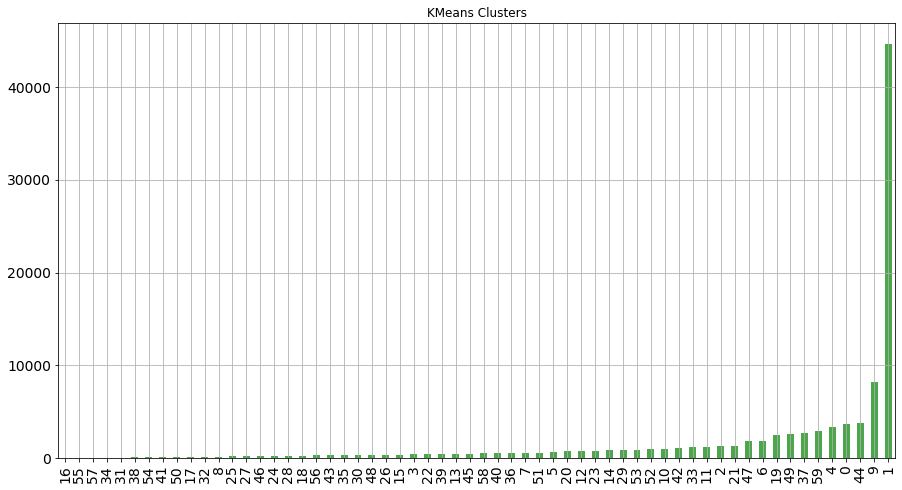

In [13]:
pd.Series(Counter(km.labels_)).sort_values().plot(kind='bar',
                                    rot=90, 
                                    figsize=(15, 8),
                                    fontsize=14,
                                    color='green',
                                    title='KMeans Clusters',
                                    grid=True,
                                    alpha=0.70);

In [37]:
df.loc[df['km_bi_30'] == 11, 'CleanJobTitle'].head(20)

2423                  Pt Produce Associate - Food Lion
2994        Pt Frozen Food/Dairy Associate - Food Lion
3506                  Pt Grocery Associate - Food Lion
4414                    Pt Sales Associate - Food Lion
5269           Center Store Grocery Manager- Food Lion
7764                Pt Perishable Associate- Food Lion
9234        Pt Quality Assurance Associate - Food Lion
9789     Pt Center Store Grocery Associate - Food Lion
12078                   Pt Sales Associate - Food Lion
14725                          Meat Cutter - Food Lion
15403                         Dsd Receiver - Food Lion
15557                          Meat Cutter - Food Lion
15770                 Pt Grocery Associate - Food Lion
15888             Pt Deli/Bakery Associate - Food Lion
17862             Dry Lead And Trainer Asm - Food Lion
18322                 Pt Service Associate - Food Lion
19441                Deli/Bakery Associate - Food Lion
19995             Pt Deli/Bakery Associate - Food Lion
20113     

## KMeans Approach the TF-IDF (TGIF) 😃🙌🏼 Way

# Section III - Clustering the Job Descriptions

For this section we will use a 10k random sample.

In [14]:
df.columns

Index(['Language', 'CanonCity', 'CanonState', 'CleanJobTitle', 'JobDate',
       'JobText', 'JobID', 'Latitude', 'Longitude', 'CanonPostalCode',
       'CanonCounty', 'DivisionCode', 'LMA', 'MSA', 'CanonEmployer',
       'CanonJobTitle', 'ConsolidatedONET', 'CanonIntermediary',
       'InternshipFlag', 'Source', 'CanonSkillClusters', 'CanonSkills',
       'IsDuplicate', 'CanonMinimumDegree', 'CanonRequiredDegrees', 'CIPCode',
       'MinExperience', 'ConsolidatedInferredNAICS', 'BGTOcc',
       'MaxAnnualSalary', 'MaxHourlySalary', 'MinAnnualSalary',
       'MinHourlySalary', 'CanonJobHours', 'CanonJobType',
       'CanonYearsOfExperienceCanonLevel', 'CanonYearsOfExperienceLevel',
       'ConsolidatedDegreeLevels', 'ConsolidatedTitle', 'MaxDegreeLevel',
       'MinDegreeLevel', 'BGTSubOcc', 'YearsOfExperience', 'year',
       'clean_text', 'charac_text_len', 'low_clean', 'list_job_text',
       'list_title_words', 'len_job_text', 'normal_text', 'normal_titles',
       'titles_uni_5', '

In [15]:
%%time

small_df = df.sample(5000).copy()

CPU times: user 22.9 ms, sys: 6.93 ms, total: 29.8 ms
Wall time: 28.8 ms


In [16]:
del df

In [17]:
small_df.shape

(5000, 88)

In [18]:
%%time

count_vect_uni = CountVectorizer(ngram_range=(1, 1), min_df=10, max_df=0.85) 
count_vect_bi = CountVectorizer(ngram_range=(1, 2), min_df=10, max_df=0.85)
count_vect_tri = CountVectorizer(ngram_range=(1, 3), min_df=10, max_df=0.85)

cv_text_uni = count_vect_uni.fit_transform(small_df['normal_text'].values)
cv_text_bi = count_vect_bi.fit_transform(small_df['normal_text'].values)
cv_text_tri = count_vect_tri.fit_transform(small_df['normal_text'].values)

cv_text_uni.shape, cv_text_bi.shape, cv_text_tri.shape

CPU times: user 20.7 s, sys: 918 ms, total: 21.6 s
Wall time: 21.8 s


((5000, 8143), (5000, 34273), (5000, 49328))

In [46]:
cvs_names = ['cv_text_uni', 'cv_text_bi', 'cv_text_tri']

cvs_names[0][3:]

'text_uni'

In [19]:
%%time

num_clusters = np.arange(5, 61, 5)
cvs = [cv_text_uni, cv_text_bi, cv_text_tri]
cvs_names = ['cv_text_uni', 'cv_text_bi', 'cv_text_tri']

for i in num_clusters:
    
    for s, r in zip(cvs, cvs_names):

        km = KMeans(n_clusters=i, # how many clusters do we want
            max_iter=10000, # reshuffle each centroid x number of times
            n_init=25, # that x num of times can be set here
            random_state=42,
            n_jobs=4 # number of cpu's to use in the computation
           )
        
        
        km.fit(s)
        
        model_name = (r[3:] + '_' + str(i))
        
        small_df[model_name] = km.labels_
        
        filename = (model_name + '.pkl')
        
        pickle.dump(km, open(filename, 'wb'))
    
    print(f"Done with k = {i}")

Done with k = 5
Done with k = 10
Done with k = 15
Done with k = 20
Done with k = 25
Done with k = 30
Done with k = 35
Done with k = 40
Done with k = 45
Done with k = 50
Done with k = 55
Done with k = 60
CPU times: user 13.9 s, sys: 20.2 s, total: 34.1 s
Wall time: 10h 25min 31s


In [20]:
small_df.head()

,Language,CanonCity,CanonState,CleanJobTitle,JobDate,JobText,JobID,Latitude,Longitude,CanonPostalCode,CanonCounty,DivisionCode,LMA,MSA,CanonEmployer,CanonJobTitle,ConsolidatedONET,CanonIntermediary,InternshipFlag,Source,CanonSkillClusters,CanonSkills,IsDuplicate,CanonMinimumDegree,CanonRequiredDegrees,CIPCode,MinExperience,ConsolidatedInferredNAICS,BGTOcc,MaxAnnualSalary,MaxHourlySalary,MinAnnualSalary,MinHourlySalary,CanonJobHours,CanonJobType,CanonYearsOfExperienceCanonLevel,CanonYearsOfExperienceLevel,ConsolidatedDegreeLevels,ConsolidatedTitle,MaxDegreeLevel,MinDegreeLevel,BGTSubOcc,YearsOfExperience,year,clean_text,charac_text_len,low_clean,list_job_text,list_title_words,len_job_text,normal_text,normal_titles,titles_uni_5,titles_bi_5,titles_tri_5,titles_uni_10,titles_bi_10,titles_tri_10,titles_uni_15,titles_bi_15,titles_tri_15,titles_uni_20,titles_bi_20,titles_tri_20,titles_uni_25,titles_bi_25,titles_tri_25,titles_uni_30,titles_bi_30,titles_tri_30,titles_uni_35,titles_bi_35,titles_tri_35,titles_uni_40,titles_bi_40,titles_tri_40,titles_uni_45,titles_bi_45,titles_tri_45,titles_uni_50,titles_bi_50,titles_tri_50,titles_uni_55,titles_bi_55,titles_tri_55,titles_uni_60,titles_bi_60,titles_tri_60,text_uni_5,text_bi_5,text_tri_5,text_uni_10,text_bi_10,text_tri_10,text_uni_15,text_bi_15,text_tri_15,text_uni_20,text_bi_20,text_tri_20,text_uni_25,text_bi_25,text_tri_25,text_uni_30,text_bi_30,text_tri_30,text_uni_35,text_bi_35,text_tri_35,text_uni_40,text_bi_40,text_tri_40,text_uni_45,text_bi_45,text_tri_45,text_uni_50,text_bi_50,text_tri_50,text_uni_55,text_bi_55,text_tri_55,text_uni_60,text_bi_60,text_tri_60
82339,en,Sullivan,MO,Program Director,2017-12-22,2017-12-20 00:00:00\n\nProgram Director\n\nin ...,38312338220,38.2613,-91.1416,63080.0,Franklin,NaN,MT294118,41180: Metropolitan Statistical Area,Air Evac Lifeteam,NaN,11911100,NaN,0,Company,Specialized Skills|Public Safety and National ...,{'Building Effective Relationships': 'Speciali...,False,NaN,NaN,NaN,NaN,6219.0,11-9111.00,NaN,NaN,NaN,NaN,fulltime,permanent,NaN,NaN,NaN,Program Director,NaN,NaN,Healthcare Administrator,NaN,2017,2017-12-20 00:00:00 Program Director in Apply ...,3705,2017-12-20 00:00:00 program director in apply ...,"['2017-12-20', '00:00:00', 'Program', 'Directo...","['Program', 'Director']",506,20171220 000000 program director in apply with...,program director,1,1,1,8,1,6,5,1,1,6,3,3,11,18,6,11,13,18,32,13,2,1,13,2,31,13,17,31,1,17,54,12,7,47,12,1,2,0,0,4,7,2,0,7,9,4,11,7,1,10,18,27,10,28,34,6,33,16,9,18,16,9,26,28,38,26,14,32,30,1,17,27
91817,en,Pembroke,NC,Center Store Grocery Manager,2020-05-09,FT Center Store (Grocery) Manager\n\nFood Lion...,38776667054,34.6813,-79.1947,28372.0,Robeson,NaN,MC373130,31300: Micropolitan Statistical Area,Food Lion Incorporated,Store Manager,41101100,NaN,0,Job Board,Finance: Budget Management;Specialized Skills|...,{'Budgeting': 'Finance: Budget Management;Spec...,False,Higher Secondary Certificate,NaN,NaN,NaN,445110.0,41-1011.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,12,Store Manager,12.0,12.0,Retail Store Manager,NaN,2020,FT Center Store (Grocery) Manager Food Lion - ...,5231,ft center store (grocery) manager food lion - ...,"['FT', 'Center', 'Store', '(Grocery)', 'Manage...","['Center', 'Store', 'Grocery', 'Manager']",764,ft center store grocery manager food lion pemb...,center store grocery manager,0,1,3,2,8,7,2,8,0,15,2,10,18,10,4,18,8,2,25,8,1,5,8,1,7,8,3,7,34,3,43,16,41,50,16,9,4,2,4,9,2,5,14,2,0,14,9,2,7,8,12,11,8,15,11,9,15,13,4,12,13,4,21,13,33,10,13,50,44,35,50,44
30607,en,Greenbrae,CA,Travel Or Registered Nurse Operating Room Regi...,2020-07-19,Travel OR RN Operating Room RN at Focus Staff...,38817493592,37.8974,-122.5400,94904.0,Marin,42034.0,DV064188|MT064186,41860: Metropolitan Statistical Area|488: Comb...,Recruiting Agency,Operating Room Registered Nurse,29114100,Focus Staff,0,Job intermediary,Information Technology: Cybersecurity;Speciali...,{'Anomaly Detection': 'Information Technology:...,False,Associate's,Associ

In [21]:
small_df.shape

(5000, 124)

In [22]:
small_df.to_csv(path_out + 'km_text_approach_5k_2.csv', index=False)

In [23]:
(small_df.drop_duplicates()
         .sample(2000)
         .to_csv(path_out + 'km_text_approach_2k_unique_2.csv', index=False))

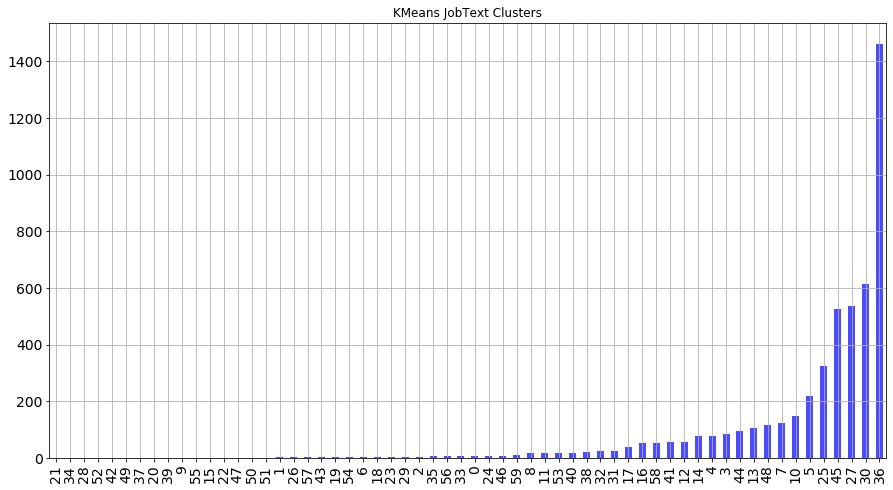

In [24]:
pd.Series(Counter(km.labels_)).sort_values().plot(kind='bar',
                                    rot=90, 
                                    figsize=(15, 8),
                                    fontsize=14,
                                    color='blue',
                                    title='KMeans JobText Clusters',
                                    grid=True,
                                    alpha=0.70);

In [60]:
small_df.loc[small_df['text_tri_6'] == 21, 'CleanJobTitle'].head(20)

57569                      Manufacturing Device Technician
38191                                       Unit Secretary
24083                                      General Manager
66945                                Flat Bed Truck Driver
10249                          Healthcare Customer Service
85510                                 Packaging Specialist
1410                              Over The Road Cdl Driver
10751                                     Systems Engineer
89585                       Inside Sales Manager, Software
73661    Geek Squad Deputy Of Counter Intelligence - Co...
76321                                   Loaner Coordinator
26679                      Sap Fi/Co Functional Consultant
18640                                   Material Processor
43573                                      Account Manager
80065                          Assistant Lms Administrator
89568                  International Corporate Tax Manager
15449                                       Technical Le

In [62]:
import os; os.cpu_count()

8

In [26]:
km.cluster_centers_

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.4       , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.01886792, 0.01886792, ..., 0.        , 0.        ,
        0.        ],
       [0.18181818, 0.18181818, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [27]:
km

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=10000,
       n_clusters=60, n_init=25, n_jobs=4, precompute_distances='auto',
       random_state=42, tol=0.0001, verbose=0)

In [30]:
km.inertia_

5028290.96377176

In [29]:
km.n_iter_

36

In [ ]:
count_vect_tri

## Hierarchical Approach

## Density Based Approach

### To Add

1. Distance metrics conditions to satisfy

In [63]:
import hdbscan

In [66]:
%%time

cluster = hdbscan.HDBSCAN(min_cluster_size=15,
                          min_samples=20,
                          ).fit(cv_text_bi)

CPU times: user 4.04 s, sys: 416 ms, total: 4.45 s
Wall time: 4.49 s


In [67]:
Counter(cluster.labels_)

Counter({-1: 5000})

#### Make your KMeans Algorithm Better

If you were to make a pipeline, this is how it would look

In [ ]:
from sklearn.pipeline import Pipeline

# you could add pca (TruncatedSVD might be better) here and the countvectorizer or td-idf vectorizer
# if you lower the dimmension to two, you will be able to visualise the results
preprocessor = Pipeline()



cluster_pipe = Pipeline(
        [
            (
             'kmeans', KMeans(
                              n_clusters=n_clusters,
                              init="k-means++",
                              n_init=25,
                              max_iter=1000,
                              random_state=42
                             )
            )
])

pipe = Pipeline([('preprocessor', preprocessor),
                 ('cluster_pipe', cluster_pipe)])

pipe.fit(data)

# if you were predicting, transform the data
preprocessed_data = pipe['preprocessor'].transform(data)

# extract the labels
km_labels = pipe['cluster_pipe']['kmeans'].labels_